In [212]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [213]:
img_path = "dog.png"

In [214]:
def convert_to_cielab(image_path):
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError("Image not found or path is incorrect")

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return cv2.cvtColor(image_rgb, cv2.COLOR_RGB2Lab)

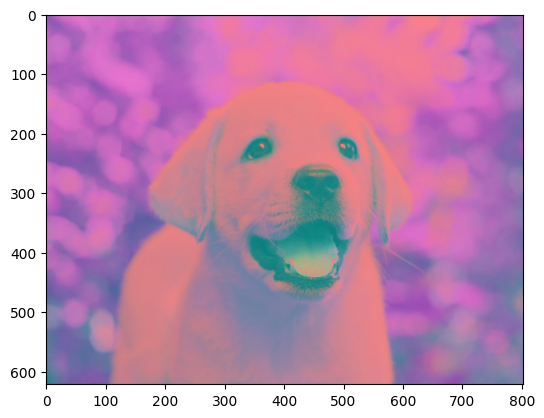

In [215]:
image_cielab = convert_to_cielab(img_path)
plt.imshow(image_cielab)
plt.show()

In [216]:
def init_cluster_centers(image, k):
    h, w = image.shape[:2]
    N = h * w
    S = int(np.sqrt(N / k))

    centers = []
    for y in range(S // 2, h, S):
        for x in range(S // 2, w, S):
            # Adjust to lowest gradient position in the 3x3 neighborhood
            adjusted_x, adjusted_y = adjust_center(image, x, y)
            l, a, b = image[adjusted_y, adjusted_x]
            centers.append([l, a, b, adjusted_x, adjusted_y])

    return np.array(centers)


def adjust_center(image, x, y):
    # 3x3 neighborhood
    neighborhood = image[y - 1 : y + 2, x - 1 : x + 2]

    # gradient magnitude in the neighborhood
    gradient = np.sum(np.gradient(neighborhood, axis=(0, 1)), axis=0)
    gradient_magnitude = np.sqrt(np.sum(gradient**2, axis=2))

    min_grad_idx = np.argmin(gradient_magnitude)
    min_y, min_x = np.unravel_index(min_grad_idx, (3, 3))

    return int(x + min_x - 1), int(y + min_y - 1)

Computes distance between each pixel and all cluster centers within its $2 \mathrm{~S} \times 2 \mathrm{~S}$ neighborhood and assigning the pixel to the cluster with the smallest distance.

The distance measure in SLIC combines both color and spatial proximity, normalized by the grid interval and compactness factor ${m}$.

$$
D=\sqrt{\frac{d_c^2}{m^2}+\frac{d_s^2}{S^2}}
$$

Where:

- $d_c$ is the Euclidean distance in color space.
- $d_s$ is the Euclidean distance in spatial coordinates.
- $S$ is the grid interval.
- $m$ is a parameter controlling the compactness of the superpixels.


In [217]:
def assign_pixels_to_clusters(image, centers, S, m):
    h, w = image.shape[:2]
    labels = -1 * np.ones((h, w), dtype=np.int32)
    distances = np.full((h, w), np.inf)

    for i, center in enumerate(centers):
        cx, cy = int(center[3]), int(center[4])
        cl, ca, cb = center[0:3]

        # 2S x 2S region around center
        min_x = max(int(cx - S), 0)
        max_x = min(int(cx + S), w)
        min_y = max(int(cy - S), 0)
        max_y = min(int(cy + S), h)

        for y in range(min_y, max_y):
            for x in range(min_x, max_x):
                # Pixel LAB values
                pl, pa, pb = image[y, x]

                # Color and spatial distances
                d_color = np.sqrt((cl - pl) ** 2 + (ca - pa) ** 2 + (cb - pb) ** 2)
                d_spatial = np.sqrt((cx - x) ** 2 + (cy - y) ** 2)

                D = np.sqrt((d_color / m) ** 2 + (d_spatial / S) ** 2)

                # Update label if this center is closer
                if D < distances[y, x]:
                    distances[y, x] = D
                    labels[y, x] = i

    return labels

In [218]:
def update_cluster_centers(image, labels, centers):
    k = len(centers)
    new_centers = np.zeros((k, 5), dtype=np.float64)
    count = np.zeros(k, dtype=np.float64)

    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            label = labels[y, x]
            l, a, b = image[y, x]

            new_centers[label, :3] += [l, a, b]
            new_centers[label, 3:5] += [x, y]
            count[label] += 1

    # empty clusters
    for i in range(k):
        if count[i] > 0:
            new_centers[i, :3] /= count[i]
            new_centers[i, 3:5] /= count[i]
        else:
            # Retain original center if no pixels are assigned to this cluster
            new_centers[i] = centers[i]

    return new_centers

In [219]:
def slic_algorithm(image, k, m, max_iter=10):
    h, w = image.shape[:2]
    N = h * w  # Total number of pixels in img
    S = int(np.sqrt(N / k))  # grid interval

    centers = init_cluster_centers(image, k)
    if len(centers) == 0:
        raise ValueError(
            "Cluster centers could not be initialized. Check image size and k value."
        )

    for _ in range(max_iter):
        labels = assign_pixels_to_clusters(image, centers, S, m)
        new_centers = update_cluster_centers(image, labels, centers)

        if np.allclose(centers, new_centers):
            break

        centers = new_centers

    return labels

In [220]:
def color_superpixels(image, labels, k):
    colored_image = np.zeros_like(image)
    for i in range(k):
        mask = labels == i
        colored_image[mask] = np.mean(image[mask], axis=0)

    return colored_image


def outline_superpixels(image, labels, boundary_color=[0, 0, 0], thickness=2):
    # mask
    label_changes = np.zeros_like(labels, dtype=bool)
    label_changes[:, 1:] = labels[:, 1:] != labels[:, :-1]
    label_changes[1:, :] |= labels[1:, :] != labels[:-1, :]

    if thickness > 1:
        kernel = np.ones((thickness, thickness), np.uint8)
        label_changes = cv2.dilate(
            label_changes.astype(np.uint8), kernel, iterations=1
        ).astype(bool)

    outlined_image = image.copy()
    outlined_image[label_changes] = boundary_color

    return outlined_image


def outline_superpixels_dual_color(image, labels, thickness=2):
    # mask
    label_changes = np.zeros_like(labels, dtype=bool)
    label_changes[:, 1:] = labels[:, 1:] != labels[:, :-1]
    label_changes[1:, :] |= labels[1:, :] != labels[:-1, :]

    kernel = np.ones((thickness, thickness), np.uint8)
    white_boundaries = cv2.dilate(label_changes.astype(np.uint8), kernel, iterations=1)

    black_boundaries = label_changes.astype(np.uint8)
    outlined_image = image.copy()

    # Draw white boundaries
    outlined_image[white_boundaries == 1] = [255, 255, 255]

    # Overlay with black boundaries
    outlined_image[black_boundaries == 1] = [0, 0, 0]

    return outlined_image

In [221]:
image = cv2.imread(img_path)
image_cielab = convert_to_cielab(img_path)

# SLIC params
num_superpixels = 50  # Number of superpixels
compactness = 30  # Compactness factor
max_iterations = 10  # Maximum iterations for the SLIC algorithm

labels = slic_algorithm(image_cielab, num_superpixels, compactness, max_iterations)

In [225]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
outlined_image = outline_superpixels(image_rgb, labels, boundary_color=[255, 255, 255])
# outlined_image = outline_superpixels(image_rgb, labels, boundary_color=[0, 0, 0])
# outlined_image = outline_superpixels_dual_color(image_rgb, labels, thickness=5)
colored_image = color_superpixels(image_rgb, labels, num_superpixels)

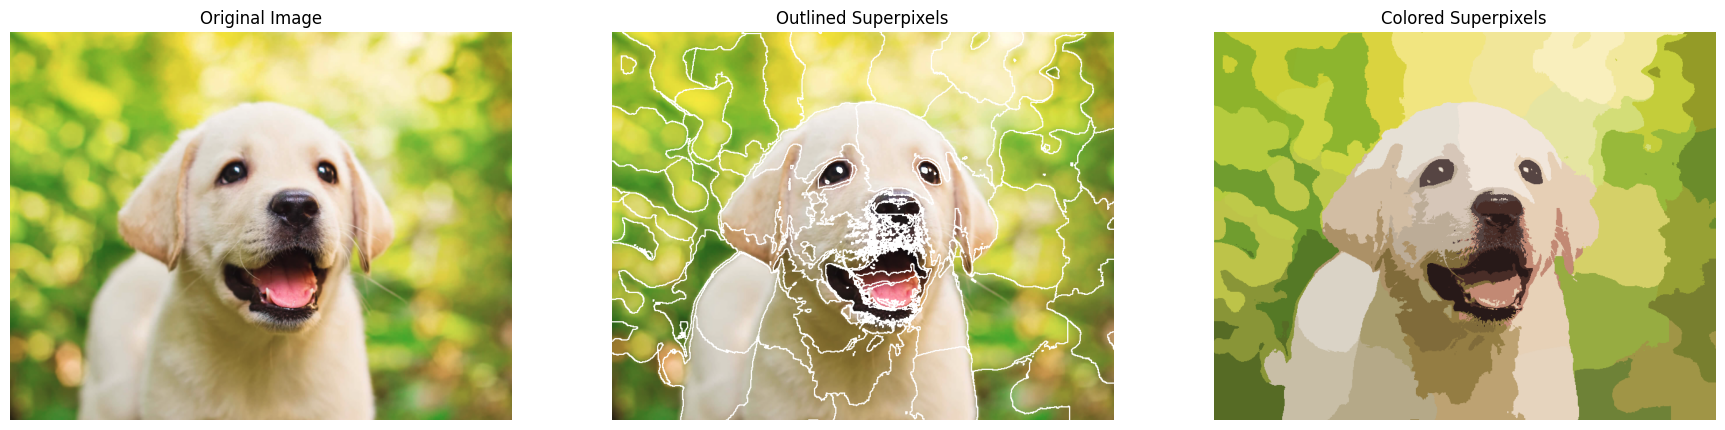

In [226]:
plt.figure(figsize=(22, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(outlined_image)
plt.title("Outlined Superpixels")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(colored_image)
plt.title("Colored Superpixels")
plt.axis("off")

plt.show()

(-0.5, 802.5, 621.5, -0.5)

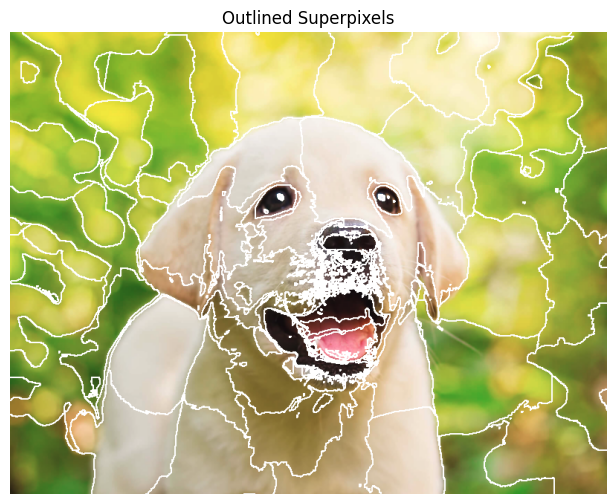

In [227]:
plt.figure(figsize=(22, 6))

plt.imshow(outlined_image)
plt.title("Outlined Superpixels")
plt.axis("off")